In [2]:
# imports
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10

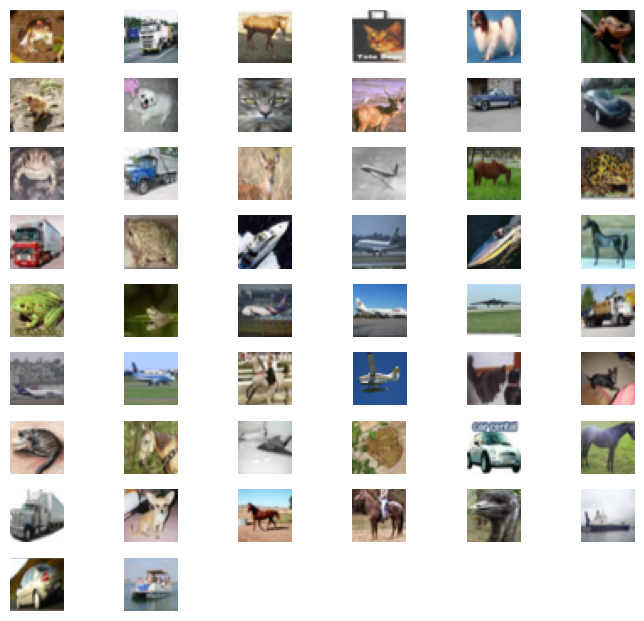

In [3]:
# prepration 
(xtr ,ytr) ,(xte ,yte) =cifar10.load_data()
xtr =(xtr/255).astype('float32')
xte =(xte/255).astype('float32')
ytr =ytr.reshape(-1,1)
yte =yte.reshape(-1,1)
plt.rc('lines' ,linewidth =4 ,linestyle =':' ,color ='blue')
plt.rc('font' ,family ='serif' ,weight ='bold' ,size =10)
plt.figure(num =1 ,dpi =100 ,figsize =(7,7))
for i in np.arange(0 ,50000 ,1000) :
  idx =int((i/1000)+1)
  plt.subplot(10 ,6 ,idx)
  plt.imshow(xtr[i])
  plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# model definition
def create_cnn(filter ,unit ,activation ,lr): 
  model =keras.Sequential()
  model.add(keras.Input(shape=(32,32,3)))
  model.add(keras.layers.Conv2D(filters =filter ,kernel_size =(2,2) ,padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation(activation))
  model.add(keras.layers.MaxPool2D(pool_size =(2,2)))
  model.add(keras.layers.Conv2D(filters =filter ,kernel_size =(2,2) ,padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation(activation))
  model.add(keras.layers.MaxPool2D(pool_size =(2,2)))
  model.add(keras.layers.Conv2D(filters =filter ,kernel_size =(2,2) ,padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation(activation))
  model.add(keras.layers.AvgPool2D(pool_size =(2,2) ,strides =(1,1)))
  model.add(keras.layers.Conv2D(filters =filter ,kernel_size =(2,2) ,padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation(activation))
  model.add(keras.layers.AvgPool2D(pool_size =(2,2) ,strides =(1,1)))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units =unit))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation(activation))
  model.add(keras.layers.Dense(units =unit))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation(activation))
  model.add(keras.layers.Dense(units =unit))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation(activation))
  model.add(keras.layers.Dense(units =unit))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation(activation))
  model.add(keras.layers.Dense(units =10))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation('softmax'))
  model.compile(optimizer =keras.optimizers.RMSprop(learning_rate=lr) ,
                loss =keras.losses.SparseCategoricalCrossentropy ,
                metrics =[keras.metrics.SparseCategoricalAccuracy])
  return model

In [9]:
# random search cross validation
kclass =KerasClassifier(create_cnn ,
                        optimizer =keras.optimizers.RMSprop(learning_rate=0.0005) ,
                        loss =keras.losses.SparseCategoricalCrossentropy ,
                        batch_size =64 ,
                        verbose =0 ,
                        epochs=1
                        )
params ={ 
    'model__filter' : [16, 32] ,
    'model__unit' : [128, 256] ,
    'model__activation' : ['relu' ,'tanh'] ,
    'model__lr' : [0.0004 ,0.0005] 
}
rs =RandomizedSearchCV(kclass ,
                       param_distributions =params , 
                       n_iter=2 , 
                       cv =4) 
rs_result =rs.fit(xtr ,ytr) 
best_params =rs_result.best_params_
cnn =create_cnn(best_params['model__filter'] ,best_params['model__unit'] ,best_params['model__activation'] ,best_params['model__lr'])

In [ ]:
# model trainnig
epochs =10
batch_size =64
def Scheduler(epoch ,lr) :
  if epoch < 30 :
    return lr
  else :
    return lr * np.exp(-0.1)
Lr_schedule =keras.callbacks.LearningRateScheduler(Scheduler ,verbose =0)
c_point =keras.callbacks.ModelCheckpoint(filepath ='model_checkpoint.weights.h5', monitor='val_sparse_categorical_accuracy' ,mode ='max' ,save_best_only =True ,save_weights_only =True)
result =cnn.fit(xtr ,ytr ,batch_size =batch_size ,epochs =epochs ,validation_data =(xte ,yte) ,callbacks =[Lr_schedule ,c_point] ,verbose =2)

In [ ]:
# model evaluation
eva =cnn.evaluate(xte ,yte ,verbose=0)
test_loss =eva[0]
test_acc_per =eva[1] *100
print(f'test_loss : {test_loss}' ,'\n')
print(f'test_accuracy : {test_acc_per} %')

test_loss : 1.5877834558486938 

test_accuracy : 44.96000111103058 %


In [ ]:
# evaluation plot(val_loss/loss)
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(num =2 ,figsize =(7,7) ,dpi =100)
plt.plot(result.history['loss'] ,color ='blue' ,label ='loss')
plt.plot(result.history['val_loss'] ,color ='red' ,label ='val_loss' ,alpha =0.7)
plt.xticks(ticks =np.arange(0 ,epochs+1 ,5))
plt.yticks(ticks =np.arange(np.min(result.history['val_loss']) ,np.max(result.history['loss']) ,0.1))
plt.xlabel(xlabel ='epochs' ,labelpad =10 ,loc ='right')
plt.ylabel(ylabel ='loss' ,labelpad =10 ,loc ='top')
plt.title(label ='val_loss/loss plot' ,pad =20 ,fontdict={'size' : 20})
plt.legend()
plt.show()

In [ ]:
# evaluation plot(val_accuracy/accuracy) 
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(num =3 ,figsize =(7,7) ,dpi =100)
plt.plot(result.history['sparse_categorical_accuracy'] ,color ='cyan' ,label ='accuracy')
plt.plot(result.history['val_sparse_categorical_accuracy'] ,color ='orange' ,label ='val_accuracy' ,alpha =0.7)
plt.xticks(ticks =np.arange(0 ,epochs+1 ,5))
plt.yticks(ticks =np.arange(np.min(result.history['sparse_categorical_accuracy']) ,np.max(result.history['val_sparse_categorical_accuracy']) ,0.1))
plt.xlabel(xlabel ='epochs' ,labelpad =10 ,loc ='right')
plt.ylabel(ylabel ='accuracy' ,labelpad =10 ,loc ='top')
plt.title(label ='val_accuracy/accuracy plot' ,pad =20 ,fontdict={'size' : 20})
plt.legend()
plt.show()